In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import seaborn as sns
import pandas as pd
import numpy as np


from matplotlib import cm
import matplotlib.pyplot as plt

import cv2
from scipy import ndimage

import warnings
warnings.filterwarnings('ignore')

In [2]:
# store login data in login.py
%run login.py

loginquery = f"""
mutation {{
  logIn(
      email:\"{login}\",
      password:\"{pwd}\") {{
    jwt {{
      token
      exp
    }}
  }}
}}
"""
import requests
url = 'https://api.numina.co/graphql'

mylogin = requests.post(url, json={'query': loginquery})
token = mylogin.json()['data']['logIn']['jwt']['token']

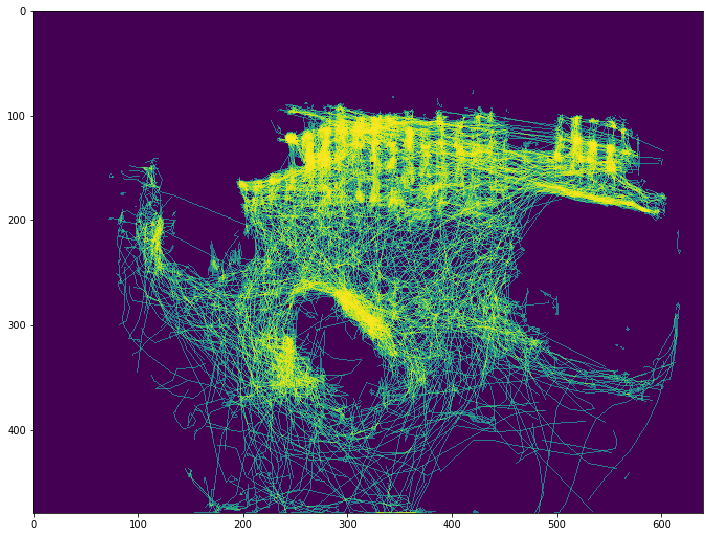

In [3]:
# Heatmaps
query3 = """
query {
  feedHeatmaps(
    serialno: "SWLSANDBOX1",
    startTime:"2019-09-26T00:00:00",
    endTime:"2019-09-27T00:00:00",
    objClasses:["pedestrian"],
    timezone:"America/New_York") {
    edges {
      node {
        time
        objClass
        heatmap
      }
    }
  }
}
"""

dec2019heat = requests.post(url, json={'query': query3}, headers = {'Authorization':token})
df = pd.DataFrame(dec2019heat.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap'])

arr = np.zeros((480,640))

for point in dec2019heat.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap']:
    arr[point[1]][point[0]] = point[2]
    
plt.figure(figsize = (12,16))
plt.imshow(arr)
plt.show()

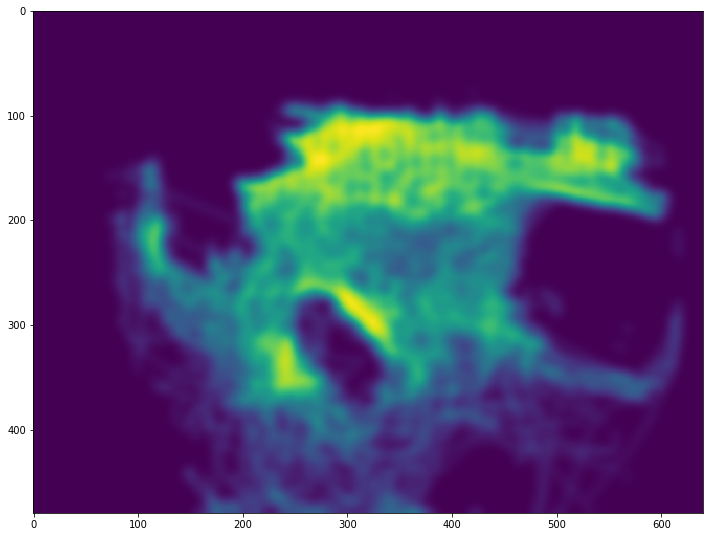

In [4]:
blurred = ndimage.gaussian_filter1d(arr, 2, axis=1)
blurred = ndimage.gaussian_filter(blurred, 5)

plt.figure(figsize = (12,16))
plt.imshow(blurred)
plt.show()

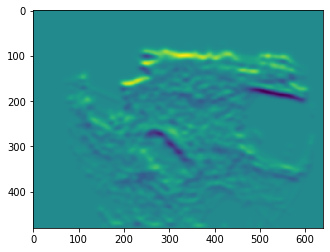

In [5]:
gx, gy = np.gradient(blurred)

Y  = np.arange(480)[::-1]
X = np.arange(640)

plt.imshow(gx);

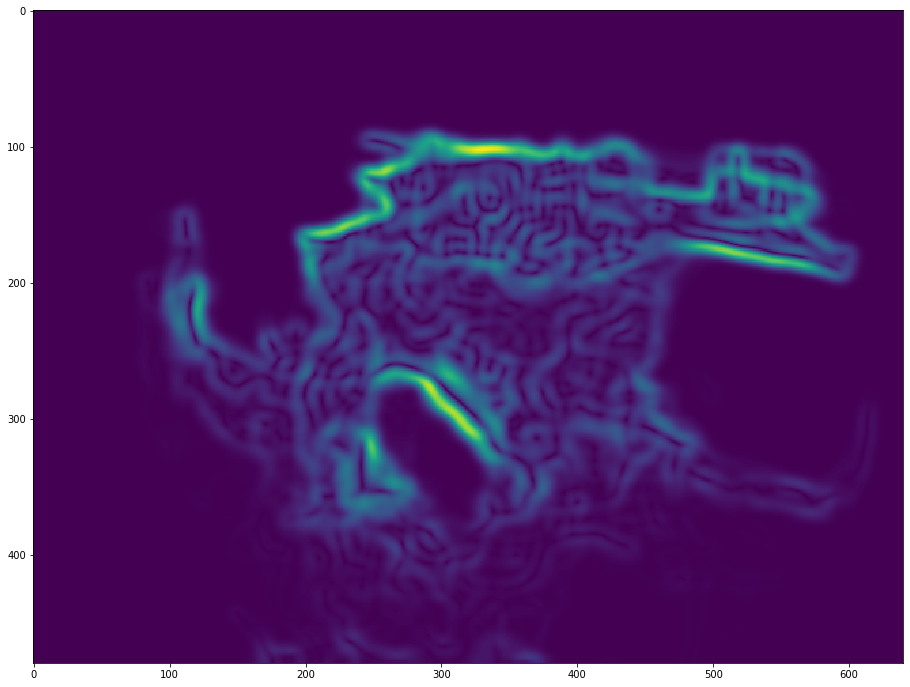

In [6]:
color = np.sqrt(gx**2 + gy**2) 
max_c = np.max(color)

color = color / max_c

plt.figure(figsize = (16,12))
plt.imshow(color * blurred);

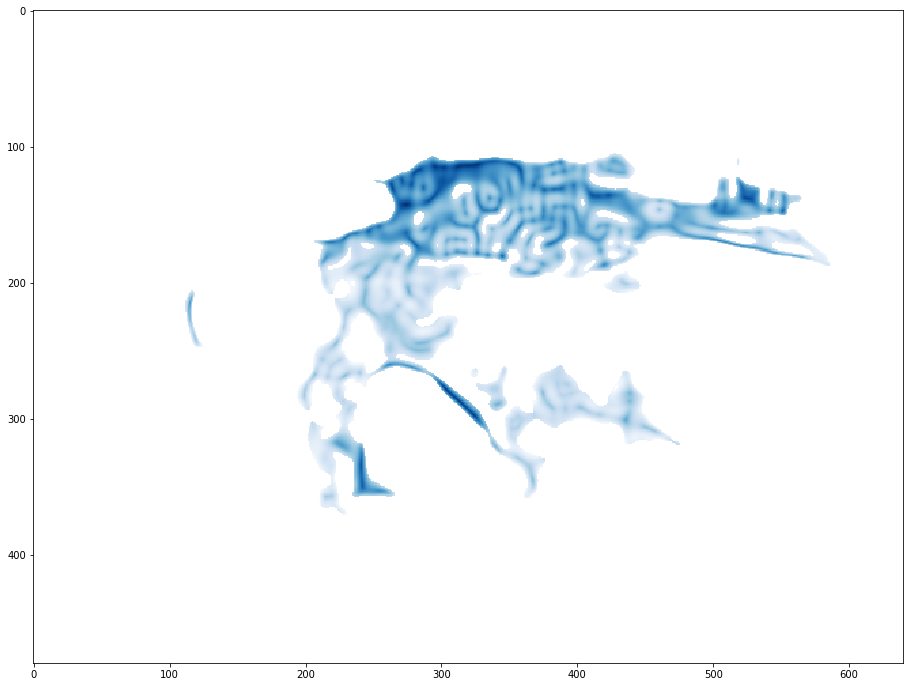

In [7]:
filter1 = np.where(blurred > 0.5, color, np.nan) # keep high density
filter2 = np.where(color < 0.2, filter1,np.nan) # keep low gradient
filter3 = (1 - filter2) ** 2 * blurred # highlighting high density and low gradient even more

plt.figure(figsize = (16,12))
plt.imshow(filter3, cmap=plt.get_cmap("Blues"));

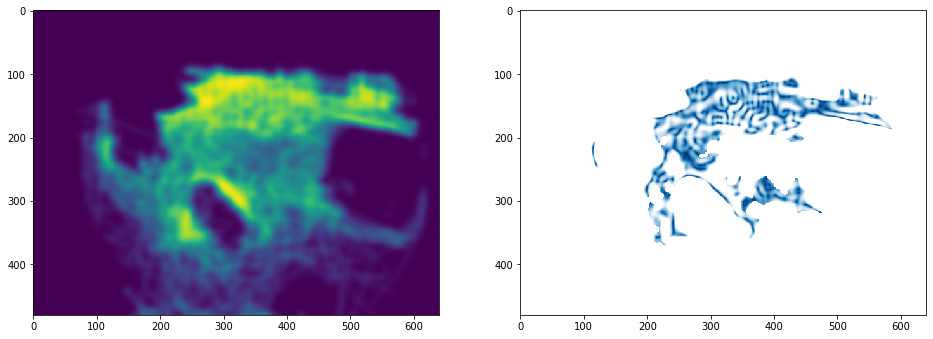

In [8]:
# high density areas with low gradient
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(blurred)
axs[1].imshow(filter2, cmap=plt.get_cmap("Blues_r"));

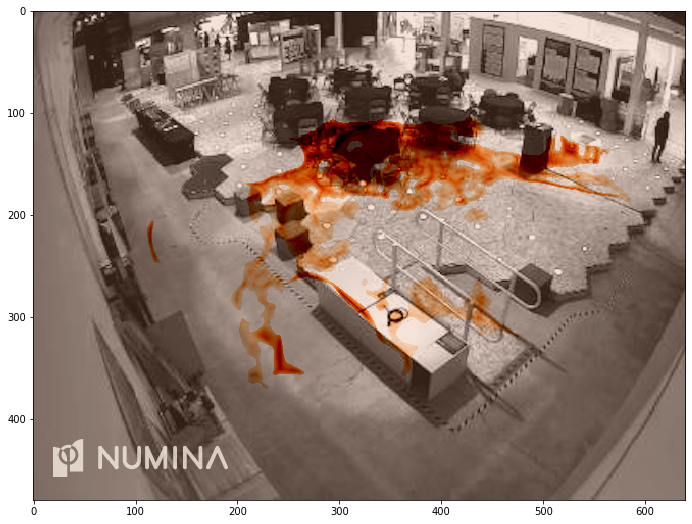

In [9]:
img = cv2.imread('img/Streetscape.png')

filter3 *= (1/np.nanmax(filter3)) # normalize array
heatmap = np.delete(np.uint8(cm.Oranges(filter3 ** 2)*255), 3, axis=2) # convert heatmap to cv2 img shape
combined_image = cv2.addWeighted(img,1,heatmap,1,-256) # combine the images

plt.figure(figsize = (12,9))
plt.imshow(combined_image);

In [10]:
devices = {'Streetscape': ('SWLSANDBOX1', 'img/Streetscape.png'), 'Outside': ('SWLSANDBOX3', 'img/Outside.png'),
           'UnderRaincoat': ('SWLSANDBOX2', 'img/UnderRaincoat.png')}

def getWeightedVelocityImage(device, startdate, enddate):
    try:
        serial = devices[device][0]
    except KeyError:
        raise Exception('Invalid device name.')
        
    query = """
    query {
      feedHeatmaps(
        serialno: "%s",
        startTime:"%s",
        endTime:"%s",
        objClasses:["pedestrian"],
        timezone:"America/New_York") {
        edges {
          node {
            time
            objClass
            heatmap
          }
        }
      }
    }
    """ % (serial, startdate.strftime("%Y-%m-%dT%H:00:00"), enddate.strftime("%Y-%m-%dT%H:00:00"))

    heatdata = requests.post(url, json={'query': query}, headers = {'Authorization':token})
    
    heatarr = np.zeros((480,640))
    
    for point in heatdata.json()['data']['feedHeatmaps']['edges'][0]['node']['heatmap']:
        heatarr[point[1]][point[0]] = point[2]
        
    blurred = ndimage.gaussian_filter1d(heatarr, 2, axis=1)
    blurred = ndimage.gaussian_filter(blurred, 5)
    
    gx, gy = np.gradient(blurred)

    Y  = np.arange(480)[::-1]
    X = np.arange(640)
    
    color = np.sqrt(gx**2 + gy**2) 
    max_c = np.max(color)

    color = color / max_c
    
    filter1 = np.where(blurred > 0.5, color, np.nan) # keep high density
    filter2 = np.where(color < 0.2, filter1,np.nan) # keep low gradient
    final = (1 - filter2) ** 2 * blurred # highlighting high density and low gradient even more
    
    img = cv2.imread(devices[device][1])
    
    final *= (1/np.nanmax(final)) # normalize array
    heatmap = np.delete(np.uint8(cm.Oranges(final ** 2)*255), 3, axis=2) # convert heatmap to cv2 img shape
    combined_image = cv2.addWeighted(img,1,heatmap,1,-256) # combine the images

    plt.figure(figsize = (12,9))
    plt.imshow(combined_image)

In [11]:
interact_manual(getWeightedVelocityImage, device=widgets.Dropdown(options=list(devices.keys())), 
                    startdate=widgets.DatePicker(value=pd.to_datetime('2019-01-01')),
             enddate=widgets.DatePicker(value=pd.to_datetime('2020-01-01')));

interactive(children=(Dropdown(description='device', options=('Streetscape', 'Outside', 'UnderRaincoat'), valu…